# Turning Data intro long format and adding spatial features

## Loading data from joined dataset

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import awswrangler as wr
import boto3

boto3.setup_default_session(profile_name='patricio_ferreira_fellow_dssgx_24')

bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"



In [89]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/holidays_deltaweather_features_df.csv"
)
df.head()

,Unnamed: 0,Time,Bayerisch Eisenstein IN,Bayerisch Eisenstein OUT,Brechhäuslau IN,Brechhäuslau OUT,Deffernik IN,Deffernik OUT,Diensthüttenstraße IN,Diensthüttenstraße OUT,...,GS max,Total,Date,Distance_to_Nearest_Holiday_Bayern,Distance_to_Nearest_Holiday_CZ,ZScore_Daily_Max_Temperature (°C),ZScore_Daily_Max_Relative Humidity (%),ZScore_Daily_Max_Precipitation (mm),ZScore_Daily_Max_Wind Speed (km/h),ZScore_Daily_Max_Sunshine Duration (min)
0,0,2017-01-01 00:00:00,NaN,NaN,257.0,412.0,NaN,NaN,NaN,NaN,...,345.0,1.0,2017-01-01,0,0,NaN,NaN,NaN,NaN,NaN
1,1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,345.0,1.0,2017-01-01,0,0,NaN,NaN,NaN,NaN,NaN
2,2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,345.0,1.0,2017-01-01,0,0,NaN,NaN,NaN,NaN,NaN
3,3,2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,345.0,1.0,2017-01-01,0,0,NaN,NaN,NaN,NaN,NaN
4,4,2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,345.0,1.0,2017-01-01,0,0,NaN,NaN,NaN,NaN,NaN


In [90]:
#drop old traffic columns

df.drop(columns= ['traffic_norm', 'traffic_abs', 'sum_IN_norm',
                  'sum_IN_abs', 'sum_OUT_norm', 'sum_OUT_abs',
                  'diff_norm', 'diff_abs'], 
                  inplace=True)

In [91]:
# Ensure the 'Time' column is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Slice the data between the specified dates without setting 'Time' as the index
df = df[(df['Time'] >= '2023-01-01') & (df['Time'] <= '2024-07-22')]

In [92]:
df.columns

Index(['Unnamed: 0', 'Time', 'Bayerisch Eisenstein IN',
       'Bayerisch Eisenstein OUT', 'Brechhäuslau IN', 'Brechhäuslau OUT',
       'Deffernik IN', 'Deffernik OUT', 'Diensthüttenstraße IN',
       'Diensthüttenstraße OUT',
       ...
       'GS max', 'Total', 'Date', 'Distance_to_Nearest_Holiday_Bayern',
       'Distance_to_Nearest_Holiday_CZ', 'ZScore_Daily_Max_Temperature (°C)',
       'ZScore_Daily_Max_Relative Humidity (%)',
       'ZScore_Daily_Max_Precipitation (mm)',
       'ZScore_Daily_Max_Wind Speed (km/h)',
       'ZScore_Daily_Max_Sunshine Duration (min)'],
      dtype='object', length=128)

## Long Format

In [93]:
import pandas as pd

def process_sensor_data(df):
    """
    Processes sensor data by melting, splitting, renaming, and pivoting to separate IN/OUT directions, 
    and then merges back non-sensor columns.

    Args:
        df (pd.DataFrame): The input DataFrame containing sensor data and other related columns.

    Returns:
        pd.DataFrame: The processed DataFrame with separate IN and OUT columns for each sensor, 
        merged back with the original non-sensor data.
    """
    # Ensure the 'Time' column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Define the renaming dictionary
    rename_dict = {
        "Bayerisch Eisenstein": ['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT'],
        "Brechhäuslau": ['Brechhäuslau IN', 'Brechhäuslau OUT'],
        "Bučina": ['Bucina MERGED IN', 'Bucina MERGED OUT'],
        "Deffernik": ['Deffernik IN', 'Deffernik OUT'],
        "Diensthüttenstraße": ['Diensthüttenstraße IN', 'Diensthüttenstraße OUT'],
        "Felswandergebiet": ['Felswandergebiet IN', 'Felswandergebiet OUT'],
        "Ferdinandsthal": ['Ferdinandsthal IN', 'Ferdinandsthal OUT'],
        "Fredenbrücke": ['Fredenbrücke IN', 'Fredenbrücke OUT'],
        "Gfäll": ['Gfäll IN', 'Gfäll OUT'],
        "Gsenget": ['Gsenget IN', 'Gsenget OUT'],
        "Klingenbrunner Wald": ['Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT'],
        "Klosterfilz": ['Klosterfilz IN', 'Klosterfilz OUT'],
        "Racheldiensthütte": ['Racheldiensthütte IN', 'Racheldiensthütte OUT'],
        "Sagwassersäge": ['Sagwassersäge IN','Sagwassersäge OUT'],
        "Scheuereck": ['Scheuereck IN', 'Scheuereck OUT'],
        "Schillerstraße": ['Schillerstraße IN', 'Schillerstraße OUT'],
        "Schwarzbachbrücke": ['Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT'],
        "TFG Falkenstein 1": ['Falkenstein 1 MERGED IN', 'Falkenstein 1 MERGED OUT'],
        "TFG Falkenstein 2": ['Falkenstein 2 IN', 'Falkenstein 2 OUT'],
        "TFG Lusen 1": ['Lusen 1 MERGED IN', 'Lusen 1 MERGED OUT'],
        "TFG Lusen 2": ['Lusen 2 IN', 'Lusen 2 OUT'],
        "TFG Lusen 3": ['Lusen 3 IN', 'Lusen 3 OUT'],
        "Trinkwassertalsperre": ['Trinkwassertalsperre MERGED IN', 'Trinkwassertalsperre MERGED OUT'],
        "Waldhausreibe": ['Waldhausreibe IN', 'Waldhausreibe OUT'],
        "Waldspielgelände": ['Waldspielgelände IN', 'Waldspielgelände OUT'],
        "Wistlberg": ['Wistlberg IN', 'Wistlberg OUT'],
    }

    # Flatten the renaming dictionary to map sensors to their IN/OUT variants
    rename_map = {sensor: name for name, sensors in rename_dict.items() for sensor in sensors}

    # List of all sensor columns
    melt_columns = list(rename_map.keys())

    # Columns that will be preserved during melting
    id_vars = [
        'Time', 'Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)',
        'Wind Speed (km/h)', 'Sunshine Duration (min)', 'Tag', 'Monat', 'Jahr', 'Wochentag',
        'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Besuchszahlen_HEH', 'Besuchszahlen_HZW',
        'Besuchszahlen_WGM', 'Parkpl_HEH_PKW', 'Parkpl_HEH_BUS', 'Parkpl_HZW_PKW', 'Parkpl_HZW_BUS',
        'Schulferien_Bayern', 'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet',
        'HZW_geoeffnet', 'WGM_geoeffnet', 'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet',
        'Waldschmidthaus_geoeffnet', 'Falkensteinschutzhaus_geoeffnet', 'Schwellhaeusl_geoeffnet',
        'Temperatur', 'Niederschlagsmenge', 'Schneehoehe', 'GS mit', 'GS max','Distance_to_Nearest_Holiday_Bayern',
       'Distance_to_Nearest_Holiday_CZ', 'ZScore_Daily_Max_Temperature (°C)',
       'ZScore_Daily_Max_Relative Humidity (%)',
       'ZScore_Daily_Max_Precipitation (mm)',
       'ZScore_Daily_Max_Wind Speed (km/h)',
       'ZScore_Daily_Max_Sunshine Duration (min)'
    ]

    # Melt the DataFrame
    df_melted = df.melt(
        id_vars=id_vars,
        value_vars=melt_columns,
        var_name='sensor_direction',
        value_name='Count'
    )

    # Split sensor_direction into 'sensor' and 'direction'
    df_melted[['sensor', 'direction']] = df_melted['sensor_direction'].str.rsplit(' ', n=1, expand=True)

    # Map the sensor names to their desired format using rename_dict
    df_melted['sensor'] = df_melted['sensor_direction'].map(rename_map)

    # Drop the original sensor_direction column
    df_melted.drop(columns=['sensor_direction'], inplace=True)

    # Extract hour from the 'Time' column
    df_melted['hour'] = df_melted['Time'].dt.hour

    # Pivot the melted DataFrame to separate IN/OUT columns
    df_pivot = df_melted.pivot_table(
        index=['Time', 'sensor', 'hour'],
        columns='direction',
        values='Count',
        aggfunc='sum'
    ).reset_index()

    # Merge back the non-sensor columns
    df_final = pd.merge(df_pivot, df[id_vars], on='Time', how='left')

    return df_final


In [94]:
df_long = process_sensor_data(df)
df_long.head()

,Time,sensor,hour,IN,OUT,Temperature (°C),Relative Humidity (%),Precipitation (mm),Wind Speed (km/h),Sunshine Duration (min),...,Schneehoehe,GS mit,GS max,Distance_to_Nearest_Holiday_Bayern,Distance_to_Nearest_Holiday_CZ,ZScore_Daily_Max_Temperature (°C),ZScore_Daily_Max_Relative Humidity (%),ZScore_Daily_Max_Precipitation (mm),ZScore_Daily_Max_Wind Speed (km/h),ZScore_Daily_Max_Sunshine Duration (min)
0,2023-01-01,Bayerisch Eisenstein,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,0.0,54.652778,338.0,0,0,0.196552,-2.684352,-0.536025,-0.90353,1.20586
1,2023-01-01,Brechhäuslau,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,0.0,54.652778,338.0,0,0,0.196552,-2.684352,-0.536025,-0.90353,1.20586
2,2023-01-01,Bučina,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,0.0,54.652778,338.0,0,0,0.196552,-2.684352,-0.536025,-0.90353,1.20586
3,2023-01-01,Deffernik,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,0.0,54.652778,338.0,0,0,0.196552,-2.684352,-0.536025,-0.90353,1.20586
4,2023-01-01,Diensthüttenstraße,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,0.0,54.652778,338.0,0,0,0.196552,-2.684352,-0.536025,-0.90353,1.20586


In [95]:
# add region column
region_mapping = {
    'Bayerisch Eisenstein': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau': 'Falkenstein-Schwellhäusl', 
    'Deffernik': 'Falkenstein-Schwellhäusl', 
    'TFG Falkenstein 1': 'Nationalparkzentrum Falkenstein', 
    'TFG Falkenstein 2': 'Nationalparkzentrum Falkenstein', 
    'Ferdinandsthal': 'Falkenstein-Schwellhäusl', 
    'Gsenget': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Scheuereck': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Schillerstraße': 'Falkenstein-Schwellhäusl', 
    'Trinkwassertalsperre': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Bučina': 'Lusen-Mauth-Finsterau', 
    'Diensthüttenstraße': 'Rachel-Spiegelau', 
    'Felswandergebiet': 'Lusen-Mauth-Finsterau', 
    'Fredenbrücke': 'Lusen-Mauth-Finsterau', 
    'Gfäll': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald': 'Rachel-Spiegelau', 
    'Klosterfilz': 'Rachel-Spiegelau', 
    'TFG Lusen 1': 'Nationalparkzentrum Lusen', 
    'TFG Lusen 2': 'Nationalparkzentrum Lusen', 
    'TFG Lusen 3': 'Nationalparkzentrum Lusen', 
    'Racheldiensthütte': 'Rachel-Spiegelau', 
    'Schwarzbachbrücke': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe': 'Lusen-Mauth-Finsterau', 
    'Waldspielgelände': 'Rachel-Spiegelau', 
    'Wistlberg': 'Lusen-Mauth-Finsterau', 
    'Sagwassersäge': 'Lusen-Mauth-Finsterau'
}

df_long['region'] = df_long['sensor'].map(region_mapping)

## Adding coordinates for each sensor

### Loading devices attributes from AWS

In [96]:

import boto3
import geopandas as gpd
import os
from io import BytesIO

# Define your S3 bucket and key
bucket_name = 'dssgx-munich-2024-bavarian-forest'
key_prefix = 'raw-data/geodata/visitor_counting_devices_with_regions/'

# Set up the AWS S3 client
s3 = boto3.client('s3')

# List all files in the S3 folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key_prefix)

# Create a temporary directory to store the downloaded files
temp_dir = '/tmp/geodata/'
os.makedirs(temp_dir, exist_ok=True)

# Download all files needed for the shapefile (.shp, .shx, .dbf, .prj, etc.)
for file in response.get('Contents', []):
    file_key = file['Key']
    file_name = os.path.basename(file_key)
    s3.download_file(bucket_name, file_key, os.path.join(temp_dir, file_name))

# Find the main .shp file in the directory
shapefile_path = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.endswith('.shp')][0]

# Load the shapefile into a GeoPandas DataFrame
gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame

gdf.head()

,Name,Zählgerä,Aufbaudatu,Abbaudatum,Zählger_1,Aktuell_Be,Anmerkunge,Besuchszah,Besuchsz_1,Besuchsz_2,Besuchsz_3,Besuchsz_4,Besuchsz_5,Trend_Vorj,BZ_23_geru,PredRegion,geometry
0,Brechhäuslau,DSo,2016-05-09,0000/00/00,PyS,Ja,None,135706,144638,118951,98419,108220,130776,21,131000,Falkenstein-Schwellhäusl,POINT (4590319.823 5440774.715)
1,Fredenbrücke,DSo,2016-05-11,0000/00/00,PyS,Ja,None,25880,24337,33821,31842,25648,27662,8,28000,Lusen-Mauth-Finsterau,POINT (4606609.392 5423279.326)
2,Felswandergebiet,DSo,2017-12-09,0000/00/00,PyS,Ja,None,18030,19434,29780,22217,21660,17261,-20,17000,Lusen-Mauth-Finsterau,POINT (4612288.964 5416968.594)
3,Waldhausreibe,DSo,2016-05-11,0000/00/00,PyS,Ja,None,79542,96788,94874,92777,91411,83715,-8,84000,Lusen-Mauth-Finsterau,POINT (4609490.763 5422456.98)
4,Waldspielgelände,DSo,2018-12-06,0000/00/00,PyS,Ja,None,0,85089,92328,94201,89923,88814,-1,89000,Rachel-Spiegelau,POINT (4599790.854 5421243.995)


In [97]:


# Reproject the GeoDataFrame to the correct CRS (if not already set)
gdf_reproj = gdf.to_crs(epsg='4326')
gdf_reproj

,Name,Zählgerä,Aufbaudatu,Abbaudatum,Zählger_1,Aktuell_Be,Anmerkunge,Besuchszah,Besuchsz_1,Besuchsz_2,Besuchsz_3,Besuchsz_4,Besuchsz_5,Trend_Vorj,BZ_23_geru,PredRegion,geometry
0,Brechhäuslau,DSo,2016-05-09,0000/00/00,PyS,Ja,None,135706,144638,118951,98419,108220,130776,21,131000,Falkenstein-Schwellhäusl,POINT (13.23532 49.09759)
1,Fredenbrücke,DSo,2016-05-11,0000/00/00,PyS,Ja,None,25880,24337,33821,31842,25648,27662,8,28000,Lusen-Mauth-Finsterau,POINT (13.45372 48.93772)
2,Felswandergebiet,DSo,2017-12-09,0000/00/00,PyS,Ja,None,18030,19434,29780,22217,21660,17261,-20,17000,Lusen-Mauth-Finsterau,POINT (13.52948 48.87999)
3,Waldhausreibe,DSo,2016-05-11,0000/00/00,PyS,Ja,None,79542,96788,94874,92777,91411,83715,-8,84000,Lusen-Mauth-Finsterau,POINT (13.49281 48.92982)
4,Waldspielgelände,DSo,2018-12-06,0000/00/00,PyS,Ja,None,0,85089,92328,94201,89923,88814,-1,89000,Rachel-Spiegelau,POINT (13.36018 48.92056)
5,Bučina,DSo,2017-10-19,0000/00/00,MUL,Ja,None,79052,75083,73840,55735,70272,70076,0,70000,Lusen-Mauth-Finsterau,POINT (13.58836 48.96523)
6,Ferdinandsthal,DSo,2017-10-20,0000/00/00,PyS,Ja,None,24076,28332,23989,20342,25765,28291,10,28000,Falkenstein-Schwellhäusl,POINT (13.23609 49.11369)
7,Gsenget,DSo,2022-10-12,0000/00/00,MUL,Ja,zuvor Pyrosensor eingebaut vom 19.10.2017 bis ...,0,0,0,0,0,17285,0,17000,Scheuereck-Schachten-Trinkwassertalsperre,POINT (13.34863 49.08078)
8,Trinkwassertalsperre,DSo,2016-05-09,0000/00/00,MUL,Ja,None,20320,19949,26242,19696,16276,23124,42,23000,Scheuereck-Schachten-Trinkwassertalsperre,POINT (13.36835 49.00407)
9,TFG Lusen 1,DSo,2020-07-30,0000/00/00,Evo,Ja,None,0,0,0,116905,124864,136121,9,136000,Nationalparkzentrum Lusen,POINT (13.48757 48.89287)


In [98]:

# Swap coordinates manually if projection fixes don't work
gdf_reproj["geometry"] = gdf_reproj["geometry"].apply(lambda geom: geom.coords[::-1] if geom.type == "POINT" else geom)


gdf_reproj

,Name,Zählgerä,Aufbaudatu,Abbaudatum,Zählger_1,Aktuell_Be,Anmerkunge,Besuchszah,Besuchsz_1,Besuchsz_2,Besuchsz_3,Besuchsz_4,Besuchsz_5,Trend_Vorj,BZ_23_geru,PredRegion,geometry
0,Brechhäuslau,DSo,2016-05-09,0000/00/00,PyS,Ja,None,135706,144638,118951,98419,108220,130776,21,131000,Falkenstein-Schwellhäusl,POINT (13.23532 49.09759)
1,Fredenbrücke,DSo,2016-05-11,0000/00/00,PyS,Ja,None,25880,24337,33821,31842,25648,27662,8,28000,Lusen-Mauth-Finsterau,POINT (13.45372 48.93772)
2,Felswandergebiet,DSo,2017-12-09,0000/00/00,PyS,Ja,None,18030,19434,29780,22217,21660,17261,-20,17000,Lusen-Mauth-Finsterau,POINT (13.52948 48.87999)
3,Waldhausreibe,DSo,2016-05-11,0000/00/00,PyS,Ja,None,79542,96788,94874,92777,91411,83715,-8,84000,Lusen-Mauth-Finsterau,POINT (13.49281 48.92982)
4,Waldspielgelände,DSo,2018-12-06,0000/00/00,PyS,Ja,None,0,85089,92328,94201,89923,88814,-1,89000,Rachel-Spiegelau,POINT (13.36018 48.92056)
5,Bučina,DSo,2017-10-19,0000/00/00,MUL,Ja,None,79052,75083,73840,55735,70272,70076,0,70000,Lusen-Mauth-Finsterau,POINT (13.58836 48.96523)
6,Ferdinandsthal,DSo,2017-10-20,0000/00/00,PyS,Ja,None,24076,28332,23989,20342,25765,28291,10,28000,Falkenstein-Schwellhäusl,POINT (13.23609 49.11369)
7,Gsenget,DSo,2022-10-12,0000/00/00,MUL,Ja,zuvor Pyrosensor eingebaut vom 19.10.2017 bis ...,0,0,0,0,0,17285,0,17000,Scheuereck-Schachten-Trinkwassertalsperre,POINT (13.34863 49.08078)
8,Trinkwassertalsperre,DSo,2016-05-09,0000/00/00,MUL,Ja,None,20320,19949,26242,19696,16276,23124,42,23000,Scheuereck-Schachten-Trinkwassertalsperre,POINT (13.36835 49.00407)
9,TFG Lusen 1,DSo,2020-07-30,0000/00/00,Evo,Ja,None,0,0,0,116905,124864,136121,9,136000,Nationalparkzentrum Lusen,POINT (13.48757 48.89287)


In [99]:
df_long.columns

Index(['Time', 'sensor', 'hour', 'IN', 'OUT', 'Temperature (°C)',
       'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)',
       'Sunshine Duration (min)', 'Tag', 'Monat', 'Jahr', 'Wochentag',
       'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Besuchszahlen_HEH',
       'Besuchszahlen_HZW', 'Besuchszahlen_WGM', 'Parkpl_HEH_PKW',
       'Parkpl_HEH_BUS', 'Parkpl_HZW_PKW', 'Parkpl_HZW_BUS',
       'Schulferien_Bayern', 'Schulferien_CZ', 'Feiertag_Bayern',
       'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet',
       'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet',
       'Waldschmidthaus_geoeffnet', 'Falkensteinschutzhaus_geoeffnet',
       'Schwellhaeusl_geoeffnet', 'Temperatur', 'Niederschlagsmenge',
       'Schneehoehe', 'GS mit', 'GS max', 'Distance_to_Nearest_Holiday_Bayern',
       'Distance_to_Nearest_Holiday_CZ', 'ZScore_Daily_Max_Temperature (°C)',
       'ZScore_Daily_Max_Relative Humidity (%)',
       'ZScore_Daily_Max_Precipita

In [100]:
# Define target and feature columns
target_vars = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs']

numeric_features = ['Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 'Sunshine Duration (min)']

other_features = ['hour','region', 'Time', 'IN', 'OUT']

categorical_features = ['Tag', 'Monat', 'Jahr', 'Wochentag', 'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Schulferien_Bayern',
                        'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet',
                        'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet', 'Falkensteinschutzhaus_geoeffnet',
                        'Schwellhaeusl_geoeffnet','Distance_to_Nearest_Holiday_Bayern',
       'Distance_to_Nearest_Holiday_CZ', 'ZScore_Daily_Max_Temperature (°C)',
       'ZScore_Daily_Max_Relative Humidity (%)',
       'ZScore_Daily_Max_Precipitation (mm)',
       'ZScore_Daily_Max_Wind Speed (km/h)',
       'ZScore_Daily_Max_Sunshine Duration (min)']

# Combine the lists into a single list and ensure uniqueness
columns_to_keep = list(set(other_features + target_vars + numeric_features + categorical_features))

# Ensure that columns_to_keep only includes columns that exist in the DataFrame
columns_to_keep = [col for col in columns_to_keep if col in df_long.columns]

# Filter the DataFrame to keep only the desired columns
df_long = df_long[columns_to_keep]

In [101]:
agg_functions = {
    'IN': 'sum',  # Sum for IN counts
    'OUT': 'sum',  # Sum for OUT counts
}

# Assume all other columns need the mean aggregation
for col in df_long.columns:
    if col not in ['Time', 'region', 'IN', 'OUT']:
        agg_functions[col] = 'last'

# Perform the aggregation
agg_df = df_long.groupby(['Time', 'region']).agg(agg_functions).reset_index()

# Print the aggregated DataFrame
agg_df

,Time,region,IN,OUT,Schwellhaeusl_geoeffnet,Jahr,Feiertag_Bayern,Schulferien_Bayern,Distance_to_Nearest_Holiday_Bayern,Distance_to_Nearest_Holiday_CZ,...,Sunshine Duration (min),Laubfärbung,Relative Humidity (%),Wochentag,HZW_geoeffnet,Lusenschutzhaus_geoeffnet,hour,HEH_geoeffnet,Monat,ZScore_Daily_Max_Relative Humidity (%)
0,2023-01-01,Falkenstein-Schwellhäusl,0.0,0.0,True,2023.0,True,True,0,0,...,0.0,False,82.0,Sonntag,True,True,0,True,1.0,-2.684352
1,2023-01-01,Lusen-Mauth-Finsterau,1.0,63.0,True,2023.0,True,True,0,0,...,0.0,False,82.0,Sonntag,True,True,0,True,1.0,-2.684352
2,2023-01-01,Nationalparkzentrum Falkenstein,1.0,0.0,True,2023.0,True,True,0,0,...,0.0,False,82.0,Sonntag,True,True,0,True,1.0,-2.684352
3,2023-01-01,Nationalparkzentrum Lusen,0.0,0.0,True,2023.0,True,True,0,0,...,0.0,False,82.0,Sonntag,True,True,0,True,1.0,-2.684352
4,2023-01-01,Rachel-Spiegelau,0.0,0.0,True,2023.0,True,True,0,0,...,0.0,False,82.0,Sonntag,True,True,0,True,1.0,-2.684352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,2024-07-22,Lusen-Mauth-Finsterau,0.0,0.0,True,2024.0,False,False,24,16,...,0.0,False,96.0,Montag,True,True,0,True,7.0,0.837014
81794,2024-07-22,Nationalparkzentrum Falkenstein,0.0,0.0,True,2024.0,False,False,24,16,...,0.0,False,96.0,Montag,True,True,0,True,7.0,0.837014
81795,2024-07-22,Nationalparkzentrum Lusen,0.0,0.0,True,2024.0,False,False,24,16,...,0.0,False,96.0,Montag,True,True,0,True,7.0,0.837014
81796,2024-07-22,Rachel-Spiegelau,0.0,0.0,True,2024.0,False,False,24,16,...,0.0,False,96.0,Montag,True,True,0,True,7.0,0.837014


In [102]:
# Specify the data types
dtype_dict = {
    'Time': 'datetime64[ns]',
    'Temperature (°C)': 'float64',
    'Relative Humidity (%)': 'float64',
    'Precipitation (mm)': 'float64',
    'Wind Speed (km/h)': 'float64',
    'Sunshine Duration (min)': 'float64',
    'Monat': 'float64',
    'Wochentag': 'category',
    'Wochenende': 'category',
    'Jahreszeit': 'category',
    'Laubfärbung': 'category',
    'Feiertag_Bayern': 'category',
    'Feiertag_CZ': 'category',
    'HEH_geoeffnet': 'category',
    'HZW_geoeffnet': 'category',
    'WGM_geoeffnet': 'category',
    'Lusenschutzhaus_geoeffnet': 'category',
    'Racheldiensthuette_geoeffnet': 'category',
    'Falkensteinschutzhaus_geoeffnet': 'category',
    'Schwellhaeusl_geoeffnet': 'category',
    'Schulferien_Bayern': 'category',
    'Schulferien_CZ': 'category',
    'Jahr': 'float64'
}

# Apply the data types to the dataframe
agg_df = agg_df.astype(dtype_dict)

# Set 'Time' as the index
agg_df.set_index('Time', inplace=True)

In [103]:
# Get unique regions
regions = agg_df['region'].unique()

# Dictionary to store the DataFrames
dfs = {}

# Create two DataFrames for each region
for region in regions:
    # Filter the DataFrame for the current region
    df_region = agg_df[agg_df['region'] == region]
    
    # DataFrame with IN renamed to target and OUT dropped
    df_in_target = df_region.copy()
    df_in_target.rename(columns={'IN': 'target'}, inplace=True)
    df_in_target.drop(columns=['OUT'], inplace=True)
    dfs[f'{region}_in_target'] = df_in_target  # Store with unique key
    
    # DataFrame with OUT renamed to target and IN dropped
    df_out_target = df_region.copy()
    df_out_target.rename(columns={'OUT': 'target'}, inplace=True)
    df_out_target.drop(columns=['IN'], inplace=True)
    dfs[f'{region}_out_target'] = df_out_target  # Store with unique key

# Display or print keys of the dict

In [104]:
#dfs['Falkenstein-Schwellhäusl_in_target'].drop(columns="region", inplace=True)

In [105]:
dfs['Falkenstein-Schwellhäusl_in_target'].columns

Index(['region', 'target', 'Schwellhaeusl_geoeffnet', 'Jahr',
       'Feiertag_Bayern', 'Schulferien_Bayern',
       'Distance_to_Nearest_Holiday_Bayern', 'Distance_to_Nearest_Holiday_CZ',
       'Wind Speed (km/h)', 'ZScore_Daily_Max_Wind Speed (km/h)',
       'ZScore_Daily_Max_Temperature (°C)', 'Tag',
       'Racheldiensthuette_geoeffnet', 'Temperature (°C)',
       'ZScore_Daily_Max_Precipitation (mm)', 'Feiertag_CZ', 'Schulferien_CZ',
       'Falkensteinschutzhaus_geoeffnet', 'Precipitation (mm)',
       'WGM_geoeffnet', 'Wochenende', 'Jahreszeit',
       'ZScore_Daily_Max_Sunshine Duration (min)', 'Sunshine Duration (min)',
       'Laubfärbung', 'Relative Humidity (%)', 'Wochentag', 'HZW_geoeffnet',
       'Lusenschutzhaus_geoeffnet', 'hour', 'HEH_geoeffnet', 'Monat',
       'ZScore_Daily_Max_Relative Humidity (%)'],
      dtype='object')

In [106]:
from pycaret.regression import *

# Define the target variables
target = 'target'

numeric_features = ['Temperature (°C)',
       'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)',
       'Sunshine Duration (min)',
       'ZScore_Daily_Max_Relative Humidity (%)',
       'ZScore_Daily_Max_Precipitation (mm)',
       'ZScore_Daily_Max_Wind Speed (km/h)',
       'ZScore_Daily_Max_Sunshine Duration (min)', 'Distance_to_Nearest_Holiday_Bayern',
       'Distance_to_Nearest_Holiday_CZ', 'ZScore_Daily_Max_Temperature (°C)']
catgorical_features =['hour','Tag', 'Monat', 'Wochentag', 'Wochenende',
       'Jahreszeit', 'Laubfärbung', 'Feiertag_Bayern', 'Feiertag_CZ',
       'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet',
       'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet',
       'Falkensteinschutzhaus_geoeffnet', 'Schwellhaeusl_geoeffnet',
       'Schulferien_Bayern', 'Schulferien_CZ', 'Jahr']

for catfeature in catgorical_features:
    dfs['Falkenstein-Schwellhäusl_in_target'][catfeature] = dfs['Falkenstein-Schwellhäusl_in_target'][catfeature].astype(str)


print(f"\nModeling for target: {target}\n")

cols_for_modeling = [target] + numeric_features + catgorical_features
    
    # Initialize the PyCaret setup
ts_setup = setup(
        data=dfs['Falkenstein-Schwellhäusl_in_target'][cols_for_modeling],
        target=target,
        train_size=0.9,
        session_id=123,  # For reproducibility
       # seasonal_period=24,  # Assumes daily seasonality for hourly data
       # fold_strategy='timeseries',  # Use time series cross-validation
        data_split_shuffle=True,
        fold=5,  # Number of folds in time series cross-validation
        #fh=24 * 14,  # Forecast horizon of 2 weeks (24 hours * 14 days)
        numeric_features=numeric_features,
        categorical_features=catgorical_features,
        verbose=False  # Suppress output for clarity
    )
    
    # Compare models and select the best one
best_model = compare_models(exclude=["lasso", "lar", "ada", "llar", "dummy", "omp", "huber", "par", "en", "br", "ridge", "lr", "dt", "knn"])
    
    # Save the best model
save_model(best_model, f'best_model_{target}')

print(f"Best model for {target} saved.\n")




Modeling for target: target



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,5.4231,117.2563,10.8177,0.8520,0.7380,0.8193,3.5260
lightgbm,Light Gradient Boosting Machine,5.5487,126.6748,11.2501,0.8398,0.7043,0.8484,0.6120
xgboost,Extreme Gradient Boosting,5.6255,131.0966,11.4464,0.8338,0.6803,0.8297,0.5340
et,Extra Trees Regressor,5.5627,145.3669,12.0432,0.8167,0.5885,0.8679,4.1560
rf,Random Forest Regressor,5.8092,149.5550,12.2174,0.8113,0.6314,0.9778,5.3100
gbr,Gradient Boosting Regressor,7.0296,193.0554,13.8836,0.7564,0.8740,1.1539,1.3060


Transformation Pipeline and Model Successfully Saved
Best model for target saved.



EXTRATREES PYCARET

In [107]:
model = create_model("et")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4320,138.0065,11.7476,0.8142,0.5611,0.8784
1,5.6830,166.9894,12.9224,0.8063,0.5840,0.8387
2,5.3345,131.5815,11.4709,0.8301,0.5927,0.8689
3,5.5348,133.7199,11.5637,0.8057,0.5959,0.9017
4,5.8291,156.5372,12.5115,0.8271,0.6087,0.8516
Mean,5.5627,145.3669,12.0432,0.8167,0.5885,0.8679
Std,0.1763,13.9440,0.5722,0.0102,0.0158,0.0218


In [108]:
model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4129,114.0101,10.6776,0.8465,0.7270,0.7984
1,5.6195,135.2230,11.6285,0.8431,0.7467,0.7800
2,5.3080,114.6457,10.7073,0.8520,0.7460,0.8366
3,5.2696,102.8086,10.1395,0.8506,0.7221,0.8184
4,5.5056,119.5943,10.9359,0.8679,0.7481,0.8628
Mean,5.4231,117.2563,10.8177,0.8520,0.7380,0.8193
Std,0.1283,10.5295,0.4823,0.0085,0.0111,0.0289


In [109]:
len(categorical_features)

25

In [110]:
from pycaret.regression import *
import plotly.express as px
import pandas as pd

# Create the Extra Trees model
model = create_model("et")

# Extract feature importances
feature_importances = model.feature_importances_
feature_names = model.feature_names_in_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using Plotly Express
fig = px.bar(
    importance_df, 
    x='Importance', 
    y='Feature', 
    orientation='h',
    title='Feature Importances of Extra Trees Model',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'},
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Importance Score',
    yaxis_title='Features',
    showlegend=False
)

# Show the plot
fig.show()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4320,138.0065,11.7476,0.8142,0.5611,0.8784
1,5.6830,166.9894,12.9224,0.8063,0.5840,0.8387
2,5.3345,131.5815,11.4709,0.8301,0.5927,0.8689
3,5.5348,133.7199,11.5637,0.8057,0.5959,0.9017
4,5.8291,156.5372,12.5115,0.8271,0.6087,0.8516
Mean,5.5627,145.3669,12.0432,0.8167,0.5885,0.8679
Std,0.1763,13.9440,0.5722,0.0102,0.0158,0.0218


In [111]:
model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4129,114.0101,10.6776,0.8465,0.7270,0.7984
1,5.6195,135.2230,11.6285,0.8431,0.7467,0.7800
2,5.3080,114.6457,10.7073,0.8520,0.7460,0.8366
3,5.2696,102.8086,10.1395,0.8506,0.7221,0.8184
4,5.5056,119.5943,10.9359,0.8679,0.7481,0.8628
Mean,5.4231,117.2563,10.8177,0.8520,0.7380,0.8193
Std,0.1283,10.5295,0.4823,0.0085,0.0111,0.0289


Catboost from pycaret feature importance

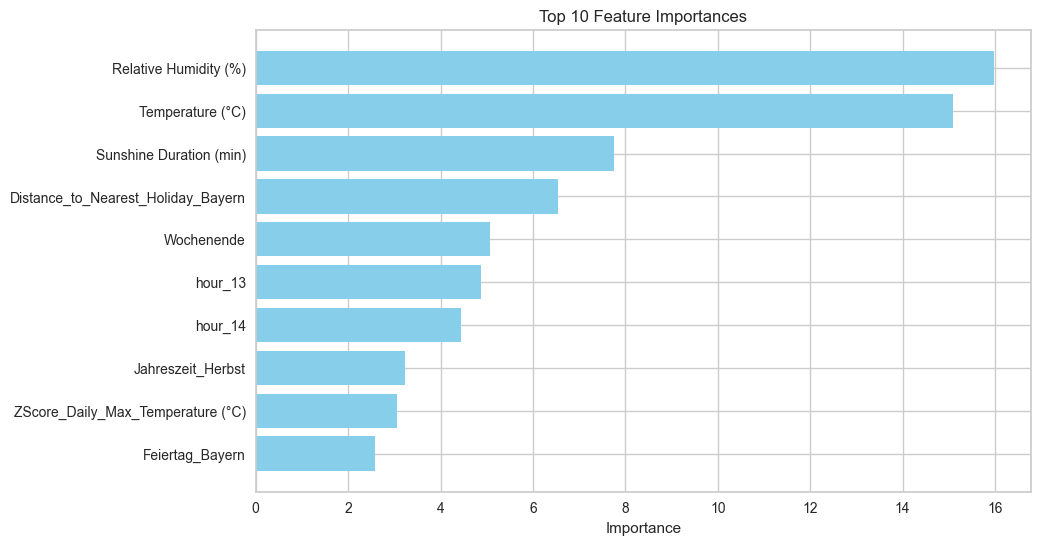

In [112]:
from catboost import CatBoostRegressor
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(model, CatBoostRegressor):
    # Get feature importances
    importances = model.get_feature_importance()

    # Ensure you have feature names, might be needed from setup or data
    feature_names = model.feature_names_

    # Create a DataFrame for easier manipulation
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort features by importance in descending order
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Select top 10 features
    top_10_features = feature_importances.head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Optimize catboost

onehot encode

In [113]:
df_encoded = pd.get_dummies(dfs['Falkenstein-Schwellhäusl_in_target'], columns=categorical_features)

In [114]:
df_encoded.columns

Index(['region', 'target', 'Wind Speed (km/h)', 'Temperature (°C)',
       'Precipitation (mm)', 'Sunshine Duration (min)',
       'Relative Humidity (%)', 'hour', 'Tag_1.0', 'Tag_10.0',
       ...
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5571013509940683',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5788080584882929',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.582468134868159',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5832791636185517',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5847779408833254',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5870633273386765',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.594672572431801',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.5986729541944176',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.6112037057343136',
       'ZScore_Daily_Max_Sunshine Duration (min)_1.6162865627518397'],
      dtype='object', length=2880)

In [115]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Assuming dfs, cols_for_modeling are already defined as in your code
# Split data into features (X) and target (y)
X = df_encoded.drop(["region", "target"], axis=1)#[cols_for_modeling]  # Features
y = df_encoded['target']               # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the parameter grid
param_grid = {
    'depth': [6, 8, 10],            # Reduced from [6, 8, 10] to [6, 8]
    'learning_rate': [0.01],    # Reduced from [0.01, 0.1, 0.2] to just [0.01]
    'iterations': [500, 1000],        # Reduced from [500, 1000] to just [500]
    'l2_leaf_reg': [1, 3, 5]        # Reduced from [1, 3, 5] to [1, 3]
}

# Initialize CatBoostRegressor
model = CatBoostRegressor(learning_rate=0.1, iterations=1000, depth=10, l2_leaf_reg=3)

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict on the test set with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))  # Using log transformation for RMSLE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print additional metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


0:	learn: 28.0072596	total: 19.2ms	remaining: 9.56s
1:	learn: 27.8384697	total: 35.8ms	remaining: 8.91s
2:	learn: 27.6883624	total: 52.2ms	remaining: 8.64s
3:	learn: 27.5431203	total: 70.2ms	remaining: 8.71s
4:	learn: 27.3811414	total: 85ms	remaining: 8.41s
5:	learn: 27.2219864	total: 106ms	remaining: 8.7s
6:	learn: 27.0619276	total: 123ms	remaining: 8.63s
7:	learn: 26.9181008	total: 139ms	remaining: 8.53s
8:	learn: 26.7847576	total: 156ms	remaining: 8.51s
9:	learn: 26.6229965	total: 172ms	remaining: 8.4s
10:	learn: 26.4656995	total: 188ms	remaining: 8.37s
11:	learn: 26.3297093	total: 207ms	remaining: 8.4s
12:	learn: 26.1766522	total: 225ms	remaining: 8.42s
13:	learn: 26.0484351	total: 242ms	remaining: 8.4s
14:	learn: 25.9203413	total: 259ms	remaining: 8.37s
15:	learn: 25.7924973	total: 278ms	remaining: 8.41s
16:	learn: 25.6578347	total: 293ms	remaining: 8.34s
17:	learn: 25.5118866	total: 311ms	remaining: 8.32s
18:	learn: 25.3741945	total: 329ms	remaining: 8.32s
19:	learn: 25.2398508	t

KeyboardInterrupt: 